### In this program we will be forcasting monthly maximum  temperature using historical max temperature data of lahore city from 1960-2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime 
from statsmodels.tsa.stattools import adfuller                
from statsmodels.tsa.seasonal import seasonal_decompose        
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("temperature_data.csv")
data.head()

,Date,tmmx
0,1/1/1960,18.1
1,2/1/1960,25.0
2,3/1/1960,25.6
3,4/1/1960,31.9
4,5/1/1960,39.0


In [4]:
# Descriptive Statistics of Data
data.describe()

,tmmx
count,768.000000
mean,30.288281
std,6.839380
min,15.500000
25%,24.600000
50%,32.650000
75%,35.400000
max,42.000000


In [5]:
#convert object dtype to datetime
data['Date']=pd.to_datetime(data['Date'])

In [6]:
data['year'] = data['Date'].dt.year
data['month'] =data['Date'].dt.month
data['day'] = data['Date'].dt.day

In [7]:
data.set_index('Date', inplace=True)

Text(0, 0.5, 'Average Max Temperature')

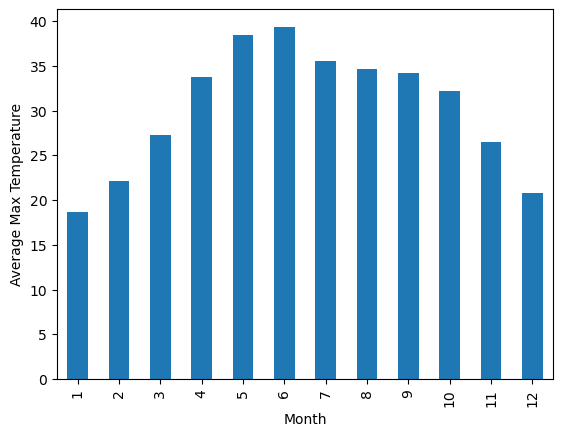

In [8]:
#This Plot shows the monthly average Max temperature
data.groupby('month')['tmmx'].mean().plot.bar()
plt.xlabel('Month')
plt.ylabel("Average Max Temperature")

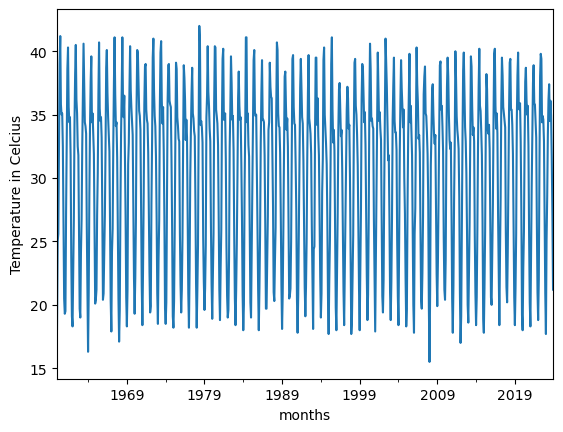

In [11]:
#This Plot shows the monthwise temeprature of years from 1960 to 2023
data['tmmx'].plot()
plt.xlabel("months")
plt.ylabel("Temperature in Celcius")
plt.show()

In [12]:
data = data.drop(['day','month','year'], axis=1)

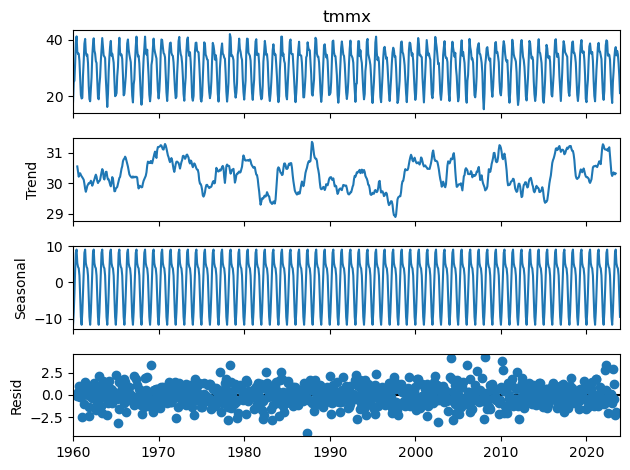

In [13]:
seasonal_decompose(data['tmmx'],period=12, model='additive').plot();

### we had performed the seasonal decompose, in order to observ the trend, seasonality in the  data. there is no such trend is observed in the data, but seasonality is there in data.

### Now we perform test to further confirm that data is stationary or not

In [14]:
print('Augmented Dickey-Fuller Test')
dftest = adfuller(data['tmmx'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test


(-6.36419173666117,
 2.4326221071372928e-08,
 20,
 747,
 {'1%': -3.439134355513998,
  '5%': -2.865416893922985,
  '10%': -2.56883447171999},
 2616.1262023570507)

### As P value is less than 0.05, that means data is stationary

<Figure size 800x400 with 0 Axes>

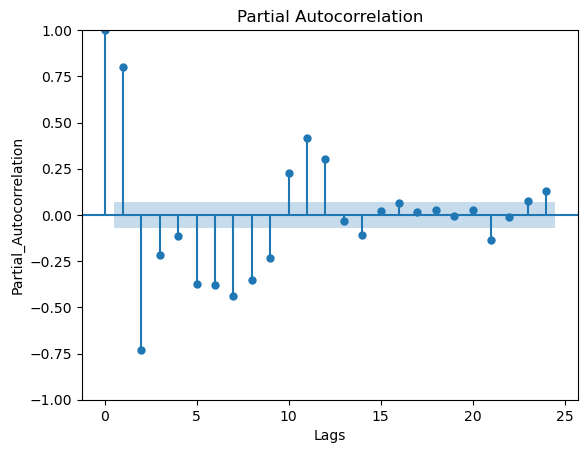

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot PACF
plt.figure(figsize=(8, 4))
plot_pacf(data['tmmx'], lags=24)  # Adjust 'lags' as needed
plt.xlabel('Lags')
plt.ylabel('Partial_Autocorrelation')
plt.show()

<Figure size 800x400 with 0 Axes>

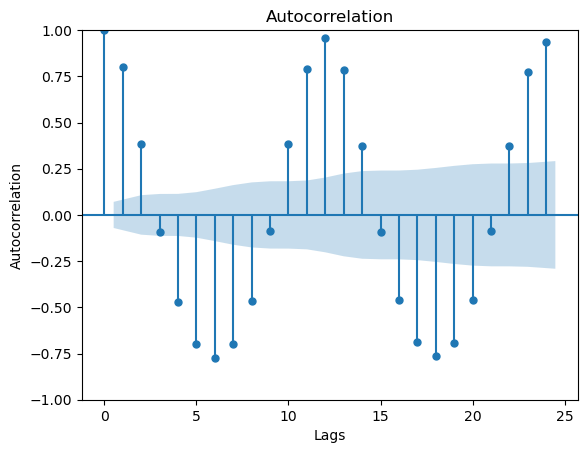

In [16]:
# Plot ACF
plt.figure(figsize=(8, 4))
plot_acf(data['tmmx'], lags=24)  # Adjust 'lags' as needed
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [17]:
len(data)

768

In [18]:
train_data = data.iloc[:672]
test_data = data.iloc[672:]
len(test_data)

96

### As Seasonality is observed in the data, therefore SARIMAX model will be better choice for forecasting

In [19]:
model = SARIMAX(train_data['tmmx'],order=(1,0,1),seasonal_order=(2,0,2, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    tmmx   No. Observations:                  672
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood               -1134.759
Date:                                 Wed, 10 Jul 2024   AIC                           2283.517
Time:                                         20:43:14   BIC                           2315.089
Sample:                                     01-01-1960   HQIC                          2295.744
                                          - 12-01-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9808      0.015     64.653      0.000       0.951       1.011
ma.L1         -0.8920      0.021    -43.489      0.000      -0.932      -0.852
ar.S.L12       0.3521      0.010     34.354      0.000       0.332       0.372
ar.S.L24       0.6478      0.010     63.582      0.000       0.628       0.668
ma.S.L12      -0.2733      0.009    -30.334      0.000      -0.291      -0.256
ma.S.L24      -0.5668      0.020    -28.800      0.000      -0.605      -0.528
sigma2         1.5549      0.072     21.515      0.000       1.413       1.697
===================================================================================
Ljung-Box (L1) (Q):                  15.77   Jarque-Bera (JB):                17.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.15
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Obtain predicted values
start=len(train_data)
end=len(train_data)+len(test_data)-1
predicted_data = results.predict(start=start, end=end,dynamic=False, typ='levels').rename('Predictions')

In [21]:
predicted_df = pd.DataFrame({'predicted temperature': predicted_data})
predicted_df['actual temperature']=test_data['tmmx']
predicted_df.head()

,predicted temperature,actual temperature
2016-01-01,17.969800,20.0
2016-02-01,21.512967,23.9
2016-03-01,27.131462,27.9
2016-04-01,33.532405,34.8
2016-05-01,38.185693,39.8


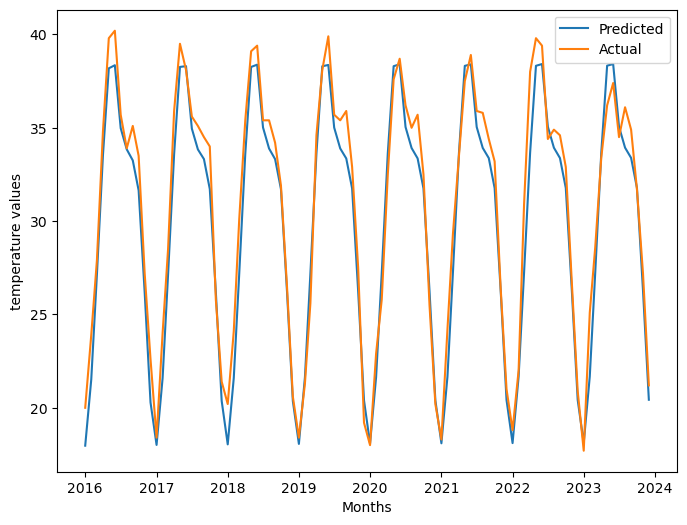

In [22]:
plt.figure(figsize=(8,6))
plt.plot(predicted_df['predicted temperature'])
plt.plot(predicted_df['actual temperature'])
plt.legend(['Predicted','Actual'])
plt.xlabel("Months")
plt.ylabel("temperature values")
plt.show()

In [23]:
mae = mean_absolute_error(test_data['tmmx'], predicted_data)
print("MAE Value is", mae)
mse = mean_squared_error(test_data['tmmx'], predicted_data)
rmse = np.sqrt(mse)
print(" \nRMSE Value is", rmse)
r2score = r2_score(test_data['tmmx'], predicted_data)
print(f'\nR2 score value: {r2score}')

MAE Value is 1.1956679281049303
 
RMSE Value is 1.4665857090264276

R2 score value: 0.9520312797622716


### As R square value is 0.95, which means that model is well fitted on data. and MAE and RMSE values are also very small, that shows model is good for forecasting, now we forcast the next month values using this model

In [24]:
start=len(data)
end=len(data)+36-1
forcasted_temp= results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Forcasted Values')

In [25]:
forcasted_data = pd.DataFrame({'Forecasted Temperature': forcasted_temp})
forcasted_data.head(10)

,Forecasted Temperature
2024-01-01,18.122282
2024-02-01,21.682755
2024-03-01,27.249355
2024-04-01,33.668791
2024-05-01,38.329978
2024-06-01,38.420196
2024-07-01,35.062824
2024-08-01,33.939641
2024-09-01,33.387877
2024-10-01,31.782134


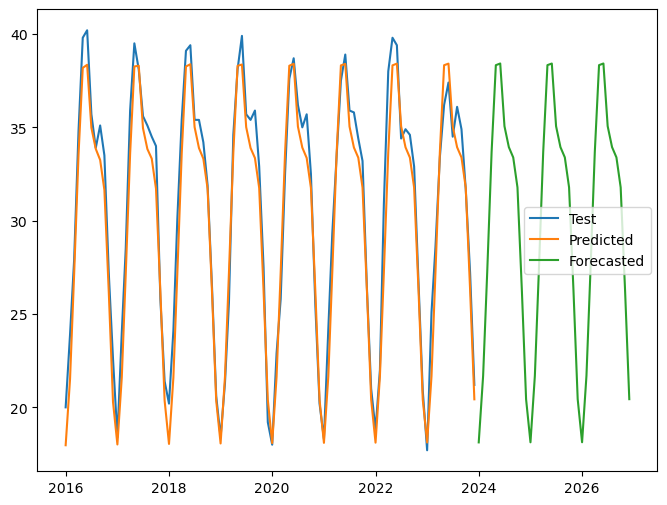

In [26]:
plt.figure(figsize=(8,6))
#plt.plot(train_data['tmmx'])
plt.plot(predicted_df['actual temperature'])
plt.plot(predicted_df['predicted temperature'])
plt.plot(forcasted_data['Forecasted Temperature'])
plt.legend(['Test','Predicted','Forecasted'])
plt.show()

### In this plot we can see that: similar temperature values are observed in forcasted results, that shows that there is not much deviation in max temperature in coming years